In [1]:
import pandas as pd
import zipfile

In [2]:
zf = zipfile.ZipFile('TrainingData.csv.zip')
df = pd.read_csv(zf.open('TrainingData.csv'), index_col = 0)
df.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,...,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,...,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,...,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN
364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,...,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


In [3]:
df.dtypes.value_counts()

object     23
float64     2
dtype: int64

## Exploring the raw data

### Summarizing the data

                 FTE         Total
count  122952.000000  3.926440e+05
mean        0.406381  1.273851e+04
std         0.447964  3.696233e+05
min         0.000000 -8.746631e+07
25%         0.000000  7.231000e+01
50%         0.100000  4.464695e+02
75%         1.000000  3.429875e+03
max         1.000000  1.297000e+08


Text(0, 0.5, 'num employees')

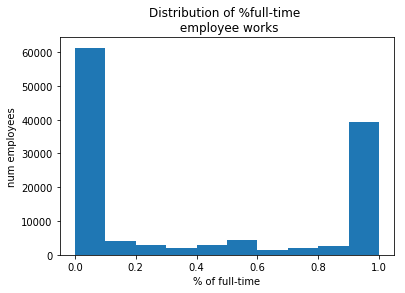

In [4]:
# Import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline

df = df[~((df['FTE']>1) | (df['FTE']<0))]

# Print the summary statistics
print(df.describe())

# Create the histogram
plt.hist(df['FTE'].dropna())

# Add title and labels
plt.title('Distribution of %full-time \n employee works')
plt.xlabel('% of full-time')
plt.ylabel('num employees')

### Encode the labels as categorical variables

In [5]:
LABELS = ['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type', 'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status']

# Define the lambda function: categorize_label
categorize_label = lambda x: x.astype('category')

# Convert df[LABELS] to a categorical type
df[LABELS] = df[LABELS].apply(categorize_label, axis = 0)

# Print the converted dtypes
print(df[LABELS].dtypes)

Function            category
Use                 category
Sharing             category
Reporting           category
Student_Type        category
Position_Type       category
Object_Type         category
Pre_K               category
Operating_Status    category
dtype: object


### Counting unique labels

Text(0, 0.5, 'Number of unique values')

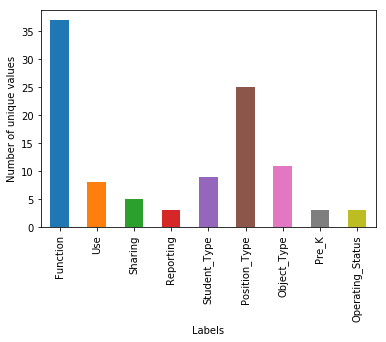

In [6]:
# Calculate number of unique values for each label: num_unique_labels
num_unique_labels = df[LABELS].apply(pd.Series.nunique)

# Plot number of unique values for each label
num_unique_labels.plot(kind = 'bar')

# Label the axes
plt.xlabel('Labels')
plt.ylabel('Number of unique values')

## Creating a simple first model

### Setting up a train-test split in scikit-learn

In [7]:
from warnings import warn

import numpy as np
import pandas as pd

def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.
        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).any():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])


def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]


def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])

In [8]:
NUMERIC_COLUMNS = ['FTE', 'Total']
LABELS = ['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type', 'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status']

# Create the new DataFrame: numeric_data_only
numeric_data_only = df[NUMERIC_COLUMNS].fillna(-1000)

# Get labels and convert to dummy variables: label_dummies
label_dummies = pd.get_dummies(df[LABELS])

# Create training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(numeric_data_only,
                                                               label_dummies,
                                                               size=0.2, 
                                                               seed=123)

# Print the info
print("X_train info:")
print(X_train.info())
print("\nX_test info:")  
print(X_test.info())
print("\ny_train info:")  
print(y_train.info())
print("\ny_test info:")  
print(y_test.info()) 

X_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 317727 entries, 134338 to 415831
Data columns (total 2 columns):
FTE      317727 non-null float64
Total    317727 non-null float64
dtypes: float64(2)
memory usage: 7.3 MB
None

X_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 79431 entries, 326408 to 413949
Data columns (total 2 columns):
FTE      79431 non-null float64
Total    79431 non-null float64
dtypes: float64(2)
memory usage: 1.8 MB
None

y_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 317727 entries, 134338 to 415831
Columns: 104 entries, Function_Aides Compensation to Operating_Status_PreK-12 Operating
dtypes: uint8(104)
memory usage: 33.9 MB
None

y_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 79431 entries, 326408 to 413949
Columns: 104 entries, Function_Aides Compensation to Operating_Status_PreK-12 Operating
dtypes: uint8(104)
memory usage: 8.5 MB
None


### Training a model

In [9]:
from warnings import filterwarnings
filterwarnings('ignore')

In [10]:
# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Create the DataFrame: numeric_data_only
numeric_data_only = df[NUMERIC_COLUMNS].fillna(-1000)

# Get labels and convert to dummy variables: label_dummies
label_dummies = pd.get_dummies(df[LABELS])

# Create training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(numeric_data_only,
                                                               label_dummies,
                                                               size=0.2, 
                                                               seed=123)

# Instantiate the classifier: clf
clf = OneVsRestClassifier(LogisticRegression(solver = 'liblinear'))

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Print the accuracy
print("Accuracy: {}".format(clf.score(X_test, y_test)))

Accuracy: 3.776862937643993e-05


### Use the model to predict values on holdout data

In [11]:
# Load the holdout data: holdout
holdout = pd.read_csv('TestData.csv', index_col = 0)

# Generate predictions: predictions
predictions = clf.predict_proba(holdout[NUMERIC_COLUMNS].fillna(-1000))

In [12]:
predictions

array([[3.58980413e-02, 6.65105995e-03, 8.02349469e-04, ...,
        1.69749819e-01, 1.98636218e-02, 8.10444069e-01],
       [3.59185581e-02, 6.65101624e-03, 8.02353335e-04, ...,
        1.69742439e-01, 1.98633226e-02, 8.10457998e-01],
       [1.20863618e-01, 1.08113150e-02, 1.04318002e-03, ...,
        4.01708136e-02, 5.85445438e-02, 9.47569896e-01],
       ...,
       [1.25268952e-01, 1.08064423e-02, 1.04352631e-03, ...,
        4.00319664e-02, 5.84862242e-02, 9.47879313e-01],
       [1.25626122e-01, 1.08033600e-02, 1.04342267e-03, ...,
        4.00491484e-02, 5.84498166e-02, 9.47873277e-01],
       [1.25222809e-01, 1.08037986e-02, 1.04339148e-03, ...,
        4.00616397e-02, 5.84550638e-02, 9.47845478e-01]])

### Writing out y results to a csv 

In [13]:
# Generate predictions: predictions
predictions = clf.predict_proba(holdout[NUMERIC_COLUMNS].fillna(-1000))

# Format predictions in DataFrame: prediction_df
prediction_df = pd.DataFrame(columns=pd.get_dummies(df[LABELS]).columns,
                             index=holdout.index,
                             data=predictions)


# Save prediction_df to csv
prediction_df.to_csv('predictions.csv')

### Creating a bag-of-words in scikit-learn

In [14]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Fill missing values in df.Position_Extra
df.Position_Extra.fillna('', inplace = True)

# Instantiate the CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern = TOKENS_ALPHANUMERIC)

# Fit to the data
vec_alphanumeric.fit(df.Position_Extra)

# Print the number of tokens and first 15 tokens
msg = "There are {} tokens in Position_Extra if we split on non-alpha numeric"
print(msg.format(len(vec_alphanumeric.get_feature_names())))
print(vec_alphanumeric.get_feature_names()[:15])

There are 385 tokens in Position_Extra if we split on non-alpha numeric
['1st', '2nd', '3rd', '4th', '56', '5th', '9th', 'a', 'ab', 'accountability', 'adaptive', 'addit', 'additional', 'adm', 'admin']


### Combining text columns for tokenization

In [15]:
# Define combine_text_columns()
def combine_text_columns(data_frame, to_drop=NUMERIC_COLUMNS + LABELS):
    """ converts all text in each row of data_frame to single vector """
    
    # Drop non-text columns that are in the df
    to_drop = set(to_drop) & set(data_frame.columns.tolist())
    text_data = data_frame.drop(to_drop, axis = 1)
    # Replace nans with blanks
    text_data.fillna('', inplace = True)
    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

### What's in a token?

In [16]:
# Import the CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create the basic token pattern
TOKENS_BASIC = '\\S+(?=\\s+)'

# Create the alphanumeric token pattern
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate basic CountVectorizer: vec_basic
vec_basic = CountVectorizer(token_pattern = TOKENS_BASIC)

# Instantiate alphanumeric CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern = TOKENS_ALPHANUMERIC)

# Create the text vector
text_vector = combine_text_columns(df)

# Fit and transform vec_basic
vec_basic.fit_transform(text_vector)

# Print number of tokens of vec_basic
print("There are {} tokens in the dataset".format(len(vec_basic.get_feature_names())))

# Fit and transform vec_alphanumeric
vec_alphanumeric.fit_transform(text_vector)

# Print number of tokens of vec_alphanumeric
print("There are {} alpha-numeric tokens in the dataset".format(len(vec_alphanumeric.get_feature_names())))

There are 4751 tokens in the dataset
There are 3282 alpha-numeric tokens in the dataset


## Improving your model

### Instantiate pipeline

In [17]:
sample_df = pd.read_csv('sample.csv')
sample_df.head()

,numeric,text,with_missing,label
0,-10.856306,NaN,4.433240,b
1,9.973454,foo,4.310229,b
2,2.829785,foo bar,2.469828,a
3,-15.062947,NaN,2.852981,b
4,-5.786003,foo bar,1.826475,a


In [18]:
# Import Pipeline
from sklearn.pipeline import Pipeline

# Import other necessary modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Split and select numeric data only, no nans 
X_train, X_test, y_train, y_test = train_test_split(sample_df[['numeric']],
                                                    pd.get_dummies(sample_df['label']), 
                                                    random_state=22)

# Instantiate Pipeline object: pl
pl = Pipeline([
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Fit the pipeline to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on sample data - numeric, no nans: ", accuracy)


Accuracy on sample data - numeric, no nans:  0.7


### Preprocessing numeric features

In [19]:
from warnings import filterwarnings
filterwarnings('ignore')

In [20]:
# Import the Imputer object
from sklearn.preprocessing import Imputer

# Create training and test sets using only numeric data
X_train, X_test, y_train, y_test = train_test_split(sample_df[['numeric', 'with_missing']],
                                                    pd.get_dummies(sample_df['label']), 
                                                    random_state=456)

# Insantiate Pipeline object: pl
pl = Pipeline([
        ('imp', Imputer()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Fit the pipeline to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on sample data - all numeric, incl nans: ", accuracy)


Accuracy on sample data - all numeric, incl nans:  0.7166666666666667


### Preprocessing text features

In [21]:
# Import the CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

sample_df['text'].fillna('', inplace = True)

# Split out only the text data
X_train, X_test, y_train, y_test = train_test_split(sample_df['text'],
                                                    pd.get_dummies(sample_df['label']), 
                                                    random_state=456)

# Instantiate Pipeline object: pl
pl = Pipeline([
        ('vec', CountVectorizer()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on sample data - just text data: ", accuracy)


Accuracy on sample data - just text data:  0.8


### Multiple types of processing: FunctionTransformer

In [22]:
# Import FunctionTransformer
from sklearn.preprocessing import FunctionTransformer

# Obtain the text data: get_text_data
get_text_data = FunctionTransformer(lambda x: x['text'], validate=False)

# Obtain the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x[['numeric', 'with_missing']], validate=False)

# Fit and transform the text data: just_text_data
just_text_data = get_text_data.fit_transform(sample_df)

# Fit and transform the numeric data: just_numeric_data
just_numeric_data = get_numeric_data.fit_transform(sample_df)

# Print head to check results
print('Text Data')
print(just_text_data.head())
print('\nNumeric Data')
print(just_numeric_data.head())

Text Data
0           
1        foo
2    foo bar
3           
4    foo bar
Name: text, dtype: object

Numeric Data
     numeric  with_missing
0 -10.856306      4.433240
1   9.973454      4.310229
2   2.829785      2.469828
3 -15.062947      2.852981
4  -5.786003      1.826475


### Multiple types of processing: FeatureUnion

In [23]:
from warnings import filterwarnings
filterwarnings('ignore')

In [24]:
# Import FeatureUnion
from sklearn.pipeline import FeatureUnion

# Split using ALL data in sample_df
X_train, X_test, y_train, y_test = train_test_split(sample_df[['numeric', 'with_missing', 'text']],
                                                    pd.get_dummies(sample_df['label']), 
                                                    random_state=22)

# Create a FeatureUnion with nested pipeline: process_and_join_features
process_and_join_features = FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )

# Instantiate nested pipeline: pl
pl = Pipeline([
        ('union', process_and_join_features),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])


# Fit pl to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on sample data - all data: ", accuracy)


Accuracy on sample data - all data:  0.85


### Using FunctionTransformer on the main dataset

In [25]:
# Import FunctionTransformer
from sklearn.preprocessing import FunctionTransformer

# Get the dummy encoding of the labels
dummy_labels = pd.get_dummies(df[LABELS])

# Get the columns that are features in the original df
NON_LABELS = [c for c in df.columns if c not in LABELS]

# Split into training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[NON_LABELS],
                                                               dummy_labels,
                                                               0.2, 
                                                               seed=123)

# Preprocess the text data: get_text_data
get_text_data = FunctionTransformer(combine_text_columns, validate = False)

# Preprocess the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)

### Add a model to the pipeline

In [26]:
from warnings import filterwarnings
filterwarnings('ignore')

In [27]:
# Complete the pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)

KeyboardInterrupt: 

### Try a different class of model

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
# Import random forest classifer
from sklearn.ensemble import RandomForestClassifier

# Edit model step in pipeline
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', RandomForestClassifier(n_estimators = 15))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)

## Learning from the experts

### Deciding what's a word

In [ ]:
# Import the CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create the text vector
text_vector = combine_text_columns(X_train)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate the CountVectorizer: text_features
text_features = CountVectorizer(token_pattern = TOKENS_ALPHANUMERIC)

# Fit text_features to the text vector
text_features.fit(text_vector)

# Print the first 10 tokens
print(text_features.get_feature_names()[:10])

### N-gram range in scikit-learn

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
# Import pipeline
from sklearn.pipeline import Pipeline

# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Import other preprocessing modules
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import chi2, SelectKBest

# Select 300 best features
chi_k = 300

# Import functional utilities
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler
from sklearn.pipeline import FeatureUnion

# Perform preprocessing
get_text_data = FunctionTransformer(combine_text_columns, validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   ngram_range=(1,2))),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

### Implement interaction modeling in scikit-learn

In [ ]:
from itertools import combinations

import numpy as np
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin


class SparseInteractions(BaseEstimator, TransformerMixin):
    def __init__(self, degree=2, feature_name_separator="_"):
        self.degree = degree
        self.feature_name_separator = feature_name_separator

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not sparse.isspmatrix_csc(X):
            X = sparse.csc_matrix(X)

        if hasattr(X, "columns"):
            self.orig_col_names = X.columns
        else:
            self.orig_col_names = np.array([str(i) for i in range(X.shape[1])])

        spi = self._create_sparse_interactions(X)
        return spi

    def get_feature_names(self):
        return self.feature_names

    def _create_sparse_interactions(self, X):
        out_mat = []
        self.feature_names = self.orig_col_names.tolist()

        for sub_degree in range(2, self.degree + 1):
            for col_ixs in combinations(range(X.shape[1]), sub_degree):
                # add name for new column
                name = self.feature_name_separator.join(self.orig_col_names[list(col_ixs)])
                self.feature_names.append(name)

                # get column multiplications value
                out = X[:, col_ixs[0]]
                for j in col_ixs[1:]:
                    out = out.multiply(X[:, j])

                out_mat.append(out)

        return sparse.hstack([X] + out_mat)

In [ ]:
# Instantiate pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   ngram_range=(1, 2))),  
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('int', SparseInteractions(degree = 2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

### Implementing the hashing trick in scikit-learn

In [ ]:
# Import HashingVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

# Get text data: text_data
text_data = combine_text_columns(X_train)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)' 

# Instantiate the HashingVectorizer: hashing_vec
hashing_vec = HashingVectorizer(token_pattern = TOKENS_ALPHANUMERIC)

# Fit and transform the Hashing Vectorizer
hashed_text = hashing_vec.fit_transform(text_data)

# Create DataFrame and print the head
hashed_df = pd.DataFrame(hashed_text.data)
print(hashed_df.head())

In [ ]:
# Import the hashing vectorizer
from sklearn.feature_extraction.text import HashingVectorizer

# Instantiate the winning model pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                     non_negative=True, norm=None, binary=False,
                                                     ngram_range=(1,2))),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('int', SparseInteractions(degree=2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])